In [ ]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit_aer

# Simon's Algorithm

In [5]:
import numpy as np
import random as rn

In [3]:
# This function intends to generate a random or non random Simon's function

def funcs(s):
    l = len(s)     # length of integer 's'
    ints = int(s,2)  # make string 's' to integer
    function = np.zeros((1,8),int)
    ###########################################
    a = input(f'Enter a true Simon function of length {2**l}, or put r for a random one:   ')
    if a == 'r':
      for i in range(int(2**l/2)):
        a = rn.randint(0,(2**l)-1)
        if a not in function:
          function[0,i] = a
          function[0,i^ints] = a           # the second place for memorizing the value of f(x) comes from x(XOR)ints
    else:
      for i in range(2**l):
        function.append(int(a[i]))

    return function

In [1]:
s = input('Give an arbitrary secret binary number (like 1010101...) s =  ')

Give an arbitrary secret binary number (like 1010101...) s =  101


In [6]:
f = funcs(s)
print(f'One of the possible function for Simon algorithm with period s={s} is function=', f)

Enter a true Simon function of length 8, or put r for a random one:   r
One of the possible function for Simon algorithm with period s=101 is function= [[6 1 2 5 1 6 5 2]]


## Qiskit Codes

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram

In [8]:
n = len(s) # Number of the required qubit

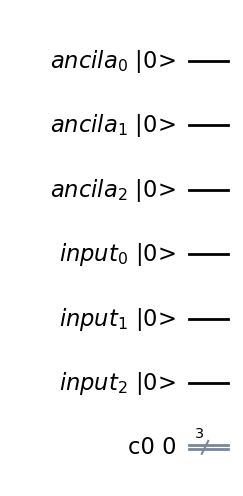

<IPython.core.display.Latex object>

In [9]:
q1 = QuantumRegister(n, name='ancila')
q2 = QuantumRegister(n , name='input')
c = ClassicalRegister(n)
qc = QuantumCircuit(q1,q2,c)
display(qc.draw('mpl',initial_state=True),Statevector(qc).draw('latex'))

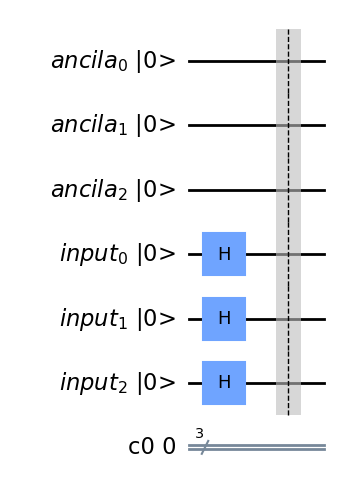

<IPython.core.display.Latex object>

In [10]:
qc.h(range(int(2*n/2),2*n))
qc.barrier()
display(qc.draw('mpl',initial_state=True),Statevector(qc).draw('latex'))

## Applying the Oracle

### Building the the Oracle Operator $U_f$ based on the $f(x)$

In [11]:
def uf(function):

  """"
  f : Simon's function
  """
  l = function.shape[1]
  s = np.zeros([l*l,l*l],dtype=int)
  for i in range(l):
    s[(i*l),(i*l)+f[0,i]] = 1
    s[(i*l)+f[0,i],(i*l)] = 1
    for j in range(1,l):
      if (i*l)+j != (i*l)+f[0,i]:
        s[(i*l)+j,(i*l)+j] = 1

  return s

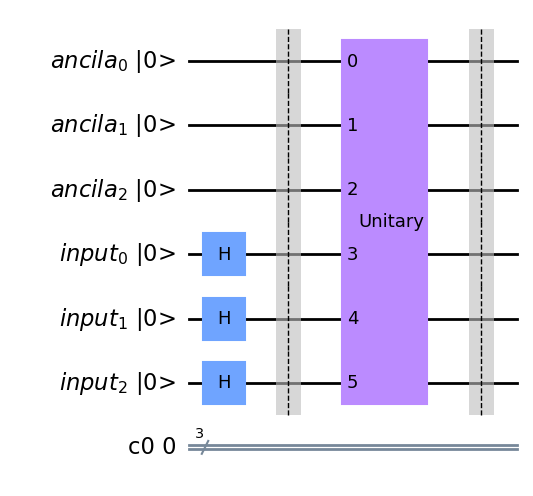

<IPython.core.display.Latex object>

In [12]:
iuf = Operator(uf(f))
qc.unitary(iuf,range(2*n))
qc.barrier()
display(qc.draw('mpl',initial_state=True),Statevector(qc).draw('latex'))

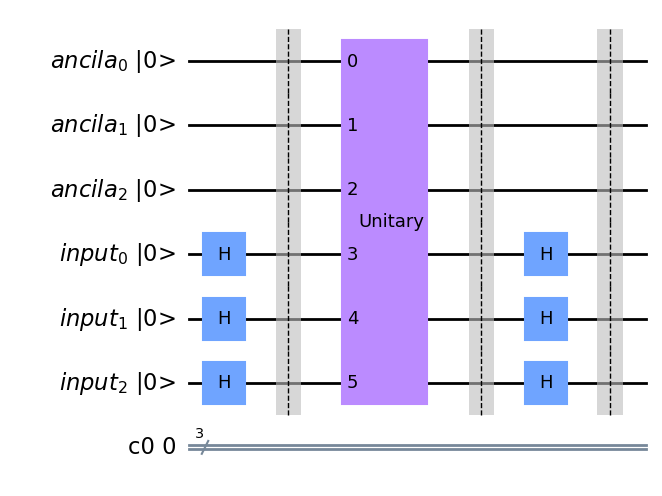

<IPython.core.display.Latex object>

In [13]:
qc.h(range(int(2*n/2),2*n))
qc.barrier()
display(qc.draw('mpl',initial_state=True),Statevector(qc).draw('latex'))

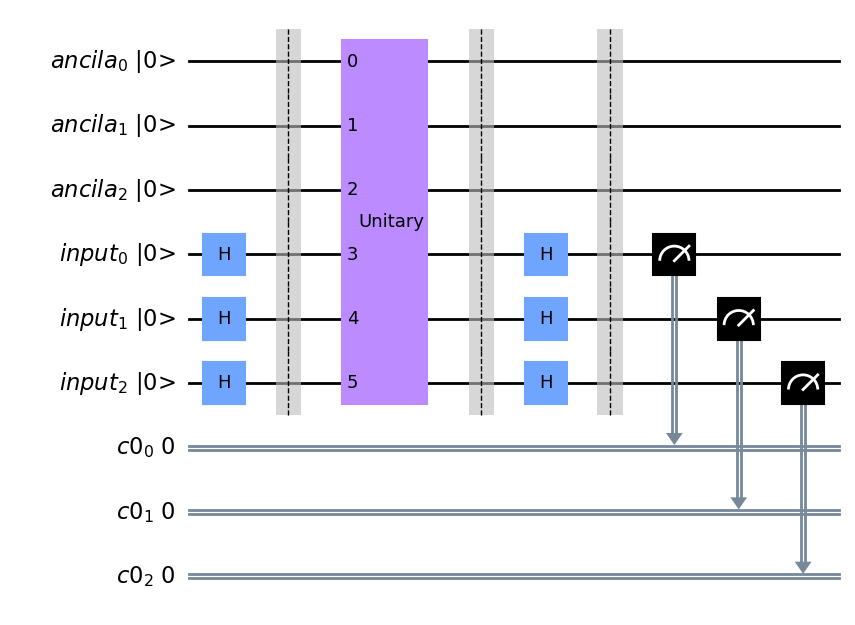

In [15]:
for i in range(int(2*n/2),2*n):
    qc.measure([i],[i%n])
qc.draw('mpl',initial_state=True,cregbundle=False)

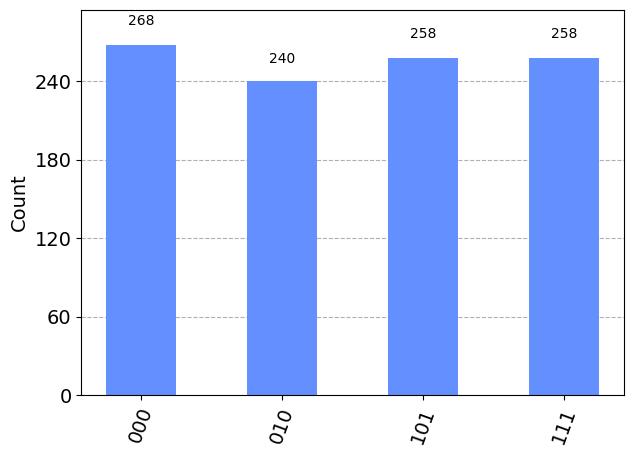

In [16]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc,backend)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [ ]:
counts

{'000': 238, '010': 256, '101': 247, '111': 283}

In [21]:
# Calculate the dot product of the results
def bdotz(b, z):
    sum = 0
    for i in range(len(b)):
        sum += int(b[i]) * int(z[i])
    return (sum % 2)

In [22]:
for z in counts:
    print( '{}.{} = {} (mod 2)'.format(s, z, bdotz(s,z)) )

101.111 = 0 (mod 2)
101.010 = 0 (mod 2)
101.000 = 0 (mod 2)
101.101 = 0 (mod 2)


## Classical Pre-Processing

Let me consider $s = s_0s_1s_2$, and based on the measurnment result we know
$$000.s_0s_1s_2 = 0 → \text{Nothing}$$
$$010.s_0s_1s_2 = s_0 \times 0 ⊕s_1 \times 1 ⊕s_2 \times 0 = 0 → s_1=0 $$
$$101.s_0s_1s_2 = s_0 \times 1 ⊕s_1 \times 0 ⊕s_2 \times 1 = 0 → s_0 \oplus s_2=0 $$
$$111.s_0s_1s_2 = s_0 \times 1 ⊕s_1 \times 1 ⊕s_2 \times 1 = 0 → s_0 \oplus s_1 \oplus s_2 = 0$$

Since $s_1=0$, and $s_0 \oplus s_2=0$, then $s_0$ and $s_2$ can be either zero and one. Although we are not interested in $s=0^{n}$ case, and final $s$ is $101$.